# Identify School Deficit Hotspots in Florianopolis


Load data and geospatial libraries


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import urbanpy as up
import h3
import libpysal
import contextily as ctx
from esda.getisord import G_Local

Load hexagon data for Florianopolis


In [45]:
hex_df = gpd.read_parquet(
    "outputs/20240129_para_hexs_with_accessibility_capacity_vars.parquet"
)

In [46]:
hex_gdf = gpd.read_parquet(
    "outputs/20240129_para_hexs_with_accessibility_capacity_vars.parquet"
)

Calculate Hotspots


Remove disconnected hexagons


In [47]:
# Select disconnected hexagons
# disconnected_hexs = [0, 1, 2, 3, 4, 985, 986, 987, 988]

# ax = hex_gdf.plot(facecolor="white", edgecolor="black")
# hex_gdf.loc[disconnected_hexs, "geometry"].plot(color="red", ax=ax)
# ax.set_axis_off()
# Add index text in red text
# for idx, row in hex_gdf.reset_index().iterrows():
# plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['index'], color='red')

In [48]:
# hex_gdf = hex_gdf.drop(disconnected_hexs, axis=0)

Define variables to be used in the analysis


In [49]:
print(hex_gdf.columns)

Index(['hex', 'territory type', 'population_2020', 'pop_6_14_years_adj',
       'income_pc', 'ensino_fundamental', 'duration_to_school_min_by_foot',
       'duration_to_school_min_by_foot_cat', 'duration_to_school_min_by_car',
       'duration_to_school_min_by_car_cat',
       'schools_within_15min_travel_time_foot',
       'schools_within_30min_travel_time_foot',
       'schools_within_15min_travel_time_car',
       'schools_within_30min_travel_time_car', 'geometry',
       'students_per_professor_FUND', 'students_per_class_FUND', 'MAT_FUND',
       'IED_NIV_1_FUND', 'IED_NIV_2_FUND', 'IED_NIV_3_FUND', 'IED_NIV_4_FUND',
       'IED_NIV_5_FUND', 'IED_NIV_6_FUND'],
      dtype='object')


In [50]:
common_var_labels = {
    "hex": "H3 Hexagon Index",
    "territory type": "Territory Type",
    "population_2020": "Population All Ages",
}

In [51]:
access_var_labels = {
    "pop_6_14_years_adj": "Population Ages 6-14",
    "income_pc": "Avg Income Per Cápita (R$)",
    "ensino_fundamental": "# of schools - Ensino Fundamental",
    "duration_to_school_min_by_foot": "Travel time to the nearest school by foot",
    "duration_to_school_min_by_foot_cat": "Travel time to the nearest school by foot categories",
    "duration_to_school_min_by_car": "Travel time to the nearest school by car",
    "duration_to_school_min_by_car_cat": "Travel time to the nearest school by car categories",
    "schools_within_15min_travel_time_foot": "# of schools at <15 minutes by foot",
    "schools_within_30min_travel_time_foot": "# of schools at <30 minutes by foot",
    "schools_within_15min_travel_time_car": "# of schools at <15 minutes by car",
    "schools_within_30min_travel_time_car": "# of schools at <30 minutes by car",
}

In [52]:
capacity_var_labels = {
    "students_per_professor_FUND": "Average # Students per Teacher",
    "students_per_class_FUND": "Average # Students per Class (calculated)",
    "MAT_FUND": "Average # Students per Class (given)",
    "IED_NIV_1_FUND": "Perc. Teachers with effort indicator - Level 1",
    "IED_NIV_2_FUND": "Perc. Teachers with effort indicator - Level 2",
    "IED_NIV_3_FUND": "Perc. Teachers with effort indicator - Level 3",
    "IED_NIV_4_FUND": "Perc. Teachers with effort indicator - Level 4",
    "IED_NIV_5_FUND": "Perc. Teachers with effort indicator - Level 5",
    "IED_NIV_6_FUND": "Perc. Teachers with effort indicator - Level 6",
}

In [53]:
access_names = [
    "pop_6_14_years_adj",
    "income_pc",
    "ensino_fundamental",
    "duration_to_school_min_by_foot",
    "schools_within_15min_travel_time_foot",
    "schools_within_30min_travel_time_foot",
    "duration_to_school_min_by_car",
    "schools_within_15min_travel_time_car",
    "schools_within_30min_travel_time_car",
]

access_features_weights = [0.2, 0.2, 0.2, 0.066, 0.066, 0.068, 0.066, 0.066, 0.068]

kring = 3  # Number of neighbors to consider

significance = 0.05  # Statistical significance level

In [54]:
try:
    assert np.array(access_features_weights).sum() == 1.0
except AssertionError as e:
    e.args += ("Features weights must sum to 1.0",)
    raise e

In [55]:
hex_gdf[access_names].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
pop_6_14_years_adj,131841.0,8.78,53.68,0.0,0.14,1.05,4.71,2832.00
income_pc,119556.0,202.47,137.76,0.0,119.79,168.37,244.41,2829.54
ensino_fundamental,6160.0,1.17,1.45,0.0,1.00,1.00,1.00,68.00
duration_to_school_min_by_foot,132303.0,42.06,146.31,0.0,3.03,11.76,34.14,6898.78
schools_within_15min_travel_time_foot,132361.0,0.19,0.93,0.0,0.00,0.00,0.00,76.00
schools_within_30min_travel_time_foot,132361.0,0.37,1.58,0.0,0.00,0.00,0.00,76.00
duration_to_school_min_by_car,132291.0,41.97,145.68,0.0,3.05,11.77,34.13,6896.92
schools_within_15min_travel_time_car,132361.0,0.88,3.12,0.0,0.00,0.00,1.00,78.00
schools_within_30min_travel_time_car,132361.0,2.44,7.03,0.0,0.00,1.00,2.00,156.00


In [56]:
def minmax_scaler(col, a=0, b=1):
    """
    Min-max scaler

    Parameters
    ----------
    col : pandas.Series
        Series to be scaled
    a : float, optional
        Min value of the scaled Series. Default is 0.
    b : float, optional
        Max value of the scaled Series. Default is 1.

    Returns
    -------
    pandas.Series
        Scaled Series
    """
    return (col - col.min()) * (b - a) / (col.max() - col.min()) + a


def linear_combination(x, w):
    """
    Linear combination of features

    Parameters
    ----------
    row : pandas.Series
        Series with features to be combined
    weights : list
        List of weights for each feature

    Returns
    -------
    float
        Linear combination of features
    """
    return np.dot(x, w)

Handle missing values


In [79]:
hex_gdf_clean = (
    hex_gdf[access_names].fillna(0)
    # .filllna(subset=["population_2020"]) # Drop rows with missing values
    # .apply(lambda col: col.fillna(col.mean()), axis=0) # Fill missing values with mean
)

Create a new column with the weighted sum of mix-max scaled features


In [82]:
hex_gdf_clean["score"] = hex_gdf_clean.apply(
    minmax_scaler, axis=0
).apply(  # Make columns values between 0 and 1
    linear_combination, w=access_features_weights, axis=1
)  # Row-wise linear combination

In [84]:
assert hex_gdf_clean["score"].shape[0] == hex_gdf.shape[0]

hex_gdf_clean["hex"] = hex_gdf["hex"]
hex_gdf_clean = gpd.GeoDataFrame(
    hex_gdf_clean, geometry=hex_gdf["geometry"]
)  # Add geometry column

Calculate spatial weights matrix


In [86]:
# https://gist.github.com/darribas/c909209bc58fc0deddf46d8ec8fce6d0
def w_from_hids(hids, kring=1):
    """
    Create a spatial weights matrix from a list of hexagons and a k-ring

    Parameters
    ----------
    hids : list
        List of hexagons ids
    kring : int, optional
        Number of rings to be considered. Default is 1.

    Returns
    -------
    pysal.lib.weights.W
        Spatial weights matrix

    """
    shids = set(hids)
    neis = {}
    for hid in hids:
        neis[hid] = list(h3.k_ring(hid, kring).intersection(shids))
    w = libpysal.weights.W(neis, id_order=hids, ids=hids)
    return w

Generate spatial weights matrix with kring neighbors


In [87]:
w_h3_k3 = w_from_hids(hex_gdf_clean["hex"].tolist(), kring=kring)

/Users/claudio/Documents/edu-brazil/.env/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 4417 disconnected components.
  warnings.warn(message)


Calculate Gi\* statistic for our score variable


In [88]:
lg_h3_k3 = G_Local(hex_gdf_clean["score"], w_h3_k3)

/Users/claudio/Documents/edu-brazil/.env/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 4417 disconnected components.
 There are 2269 islands with ids: 885f269a51fffff, 888b8a7955fffff, 888aa5768bfffff, 888a937933fffff, 88816b1831fffff, 88816a2a63fffff, 888a9a2f3bfffff, 888b9ab1a7fffff, 888ab57351fffff, 88814b7105fffff, 88806e0a4dfffff, 88814582cdfffff, 888074393bfffff, 88816ac719fffff, 88816a0e1dfffff, 888a9932abfffff, 888a905325fffff, 888069391bfffff, 888b986b49fffff, 88806e6cb9fffff, 885f254057fffff, 8880752203fffff, 88806cc4a9fffff, 888a837ab1fffff, 888045233dfffff, 888b9a36a3fffff, 888ab66d0dfffff, 888a9c8621fffff, 888a9d3ac7fffff, 888040d531fffff, 888a82aab1fffff, 888054ab49fffff, 888060b141fffff, 888a98a72dfffff, 888073d307fffff, 888a862165fffff, 888b9a25dbfffff, 888040b8d1fffff, 885f248a91fffff, 88815ba8a1fffff, 888aa031d7fffff, 888b9b41c5fffff, 888a936b1dfffff, 888a95080bfffff, 888ab659ddfffff, 

('WARNING: ', '885f269a51fffff', ' is an island (no neighbors)')
('WARNING: ', '888b8a7955fffff', ' is an island (no neighbors)')
('WARNING: ', '888aa5768bfffff', ' is an island (no neighbors)')
('WARNING: ', '888a937933fffff', ' is an island (no neighbors)')
('WARNING: ', '88816b1831fffff', ' is an island (no neighbors)')
('WARNING: ', '88816a2a63fffff', ' is an island (no neighbors)')
('WARNING: ', '888a9a2f3bfffff', ' is an island (no neighbors)')
('WARNING: ', '888b9ab1a7fffff', ' is an island (no neighbors)')
('WARNING: ', '888ab57351fffff', ' is an island (no neighbors)')
('WARNING: ', '88814b7105fffff', ' is an island (no neighbors)')
('WARNING: ', '88806e0a4dfffff', ' is an island (no neighbors)')
('WARNING: ', '88814582cdfffff', ' is an island (no neighbors)')
('WARNING: ', '888074393bfffff', ' is an island (no neighbors)')
('WARNING: ', '88816ac719fffff', ' is an island (no neighbors)')
('WARNING: ', '88816a0e1dfffff', ' is an island (no neighbors)')
('WARNING: ', '888a9932ab

/Users/claudio/Documents/edu-brazil/.env/lib/python3.11/site-packages/esda/getisord.py:514: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/claudio/Documents/edu-brazil/.env/lib/python3.11/site-packages/esda/getisord.py:443: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


Get the number of significant hexagons


In [89]:
n_sig = (lg_h3_k3.p_sim < significance).sum()
n_total = lg_h3_k3.p_sim.shape[0]
prop_sig = n_sig / n_total
print(f"Number of significant hexagons: {n_sig} out of {n_total} ({prop_sig:.2%})")

Number of significant hexagons: 58940 out of 132361 (44.53%)


Assing Gi\* and p-value to hexagons


In [90]:
hex_gdf_clean["Gi_h3_k3"] = lg_h3_k3.Gs
hex_gdf_clean["p_sim_h3_k3"] = lg_h3_k3.p_sim

In [91]:
hex_gdf_clean["Gi_h3_k3"].describe()

count    132361.000000
mean          0.000007
std           0.000006
min           0.000000
25%           0.000005
50%           0.000006
75%           0.000009
max           0.000139
Name: Gi_h3_k3, dtype: float64

Visualize the local G index after filtering not significant and unpopulated hexagons. Higher values indicate a hotspot.


In [94]:
%pip install numba

  Using cached numba-0.58.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.41.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (4.8 kB)
Using cached numba-0.58.1-cp311-cp311-macosx_11_0_arm64.whl (2.6 MB)
Using cached llvmlite-0.41.1-cp311-cp311-macosx_11_0_arm64.whl (28.8 MB)

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/claudio/Documents/edu-brazil/.env/lib/python3.11/site-packages/geopandas/plotting.py:777: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


KeyboardInterrupt: 

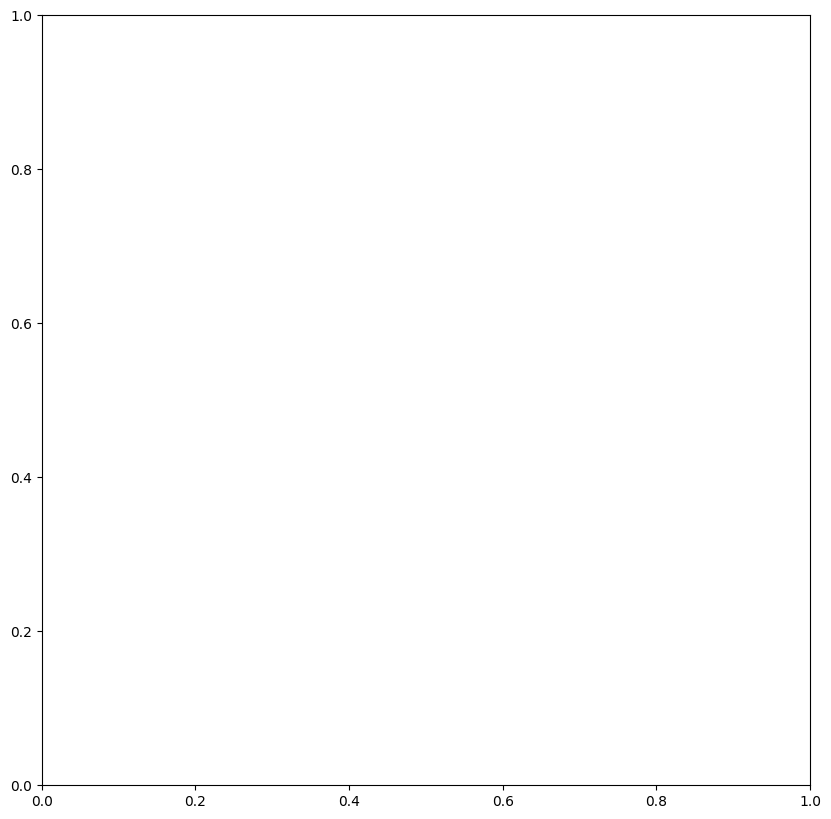

In [95]:
fig, ax = plt.subplots(figsize=(12, 10))
(
    hex_gdf_clean.query("p_sim_h3_k3 < 0.05")
    # .query("population_2020 > 0")
    .plot(column="Gi_h3_k3", cmap="OrRd_r", scheme="FisherJenks", k=4, ax=ax, alpha=0.8)
)

ax.set_axis_off()

# Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.DarkMatterNoLabels,
    crs=hex_gdf_clean.crs.to_string(),
)

plt.tight_layout()

# Remove figure white border
plt.savefig(
    "outputs/maps/flor/11-para-hotspots.png", bbox_inches="tight", pad_inches=0, dpi=300
)

plt.show()